In [2]:
# Copyright (c) Meta Platforms, Inc. and affiliates.

# Object masks from prompts with SAM

The Segment Anything Model (SAM) predicts object masks given prompts that indicate the desired object. The model first converts the image into an image embedding that allows high quality masks to be efficiently produced from a prompt. 

The `SamPredictor` class provides an easy interface to the model for prompting the model. It allows the user to first set an image using the `set_image` method, which calculates the necessary image embeddings. Then, prompts can be provided via the `predict` method to efficiently predict masks from those prompts. The model can take as input both point and box prompts, as well as masks from the previous iteration of prediction.

In [1]:
from IPython.display import display, HTML
display(HTML(
"""
<a target="_blank" href="https://colab.research.google.com/github/facebookresearch/segment-anything/blob/main/notebooks/predictor_example.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>
"""
))

## Environment Set-up

If running locally using jupyter, first install `segment_anything` in your environment using the [installation instructions](https://github.com/facebookresearch/segment-anything#installation) in the repository. If running from Google Colab, set `using_colab=True` below and run the cell. In Colab, be sure to select 'GPU' under 'Edit'->'Notebook Settings'->'Hardware accelerator'.

In [4]:
using_colab = False

In [5]:
if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'
    
    !mkdir images
    !wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/truck.jpg
    !wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/groceries.jpg
        
    !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

## Set-up

Necessary imports and helper functions for displaying points, boxes, and masks.

In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

In [3]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    


## Example image

In [4]:
image = cv2.imread('../exp/sheep.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

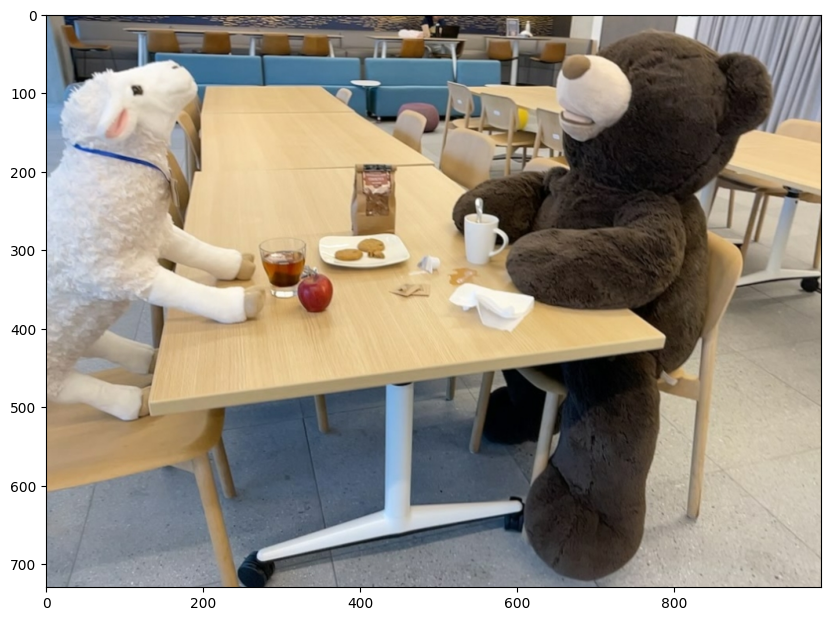

In [5]:
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis('on')
plt.show()

## Selecting objects with SAM

First, load the SAM model and predictor. Change the path below to point to the SAM checkpoint. Running on CUDA and using the default model are recommended for best results.

In [6]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor

sam_checkpoint = "./sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)

Process the image to produce an image embedding by calling `SamPredictor.set_image`. `SamPredictor` remembers this embedding and will use it for subsequent mask prediction.

In [7]:
predictor.set_image(image)

## Read box from RegionCLIP and mask it

The model can also take a box as input, provided in xyxy format.

In [15]:
import json
import re

filename = 'seg_results.json'
with open(filename, 'r') as file:
    data = json.load(file)

metadata_list = data['metadata']
classes_list = data['classes']

scores_list = data['scores']

# parse boxes list
boxes_list = data['boxes']
numbers = re.findall(r'[\d.]+', boxes_list)
float_numbers = [float(num) for num in numbers]
boxes_list = [float_numbers[i:i+4] for i in range(0, len(float_numbers), 4)]
# classes_name_list = 

mapped_items = [metadata_list[index] for index in classes_list]


In [21]:
import spacy
from scipy.spatial.distance import cosine

# clearn data
mapped_items = [item.replace('_', ' ') for item in mapped_items]
mapped_items = [item.replace('-', ' ') for item in mapped_items]

given = 'sheep'
mapped_items
nlp = spacy.load('en_core_web_md')
cosine_similarity_lst = []

for item in mapped_items:
    token1 = nlp(item)
    token2 = nlp(given)
    cosine_similarity = 1 - cosine(token1.vector, token2.vector)
    cosine_similarity_lst.append(cosine_similarity)

max_value = max(cosine_similarity_lst)
max_index = cosine_similarity_lst.index(max_value)


boxes_list[max_index]
input_box = np.array(boxes_list[max_index])

In [22]:
masks, _, _ = predictor.predict(
    point_coords=None,
    point_labels=None,
    box=input_box[None, :],
    multimask_output=False,
)

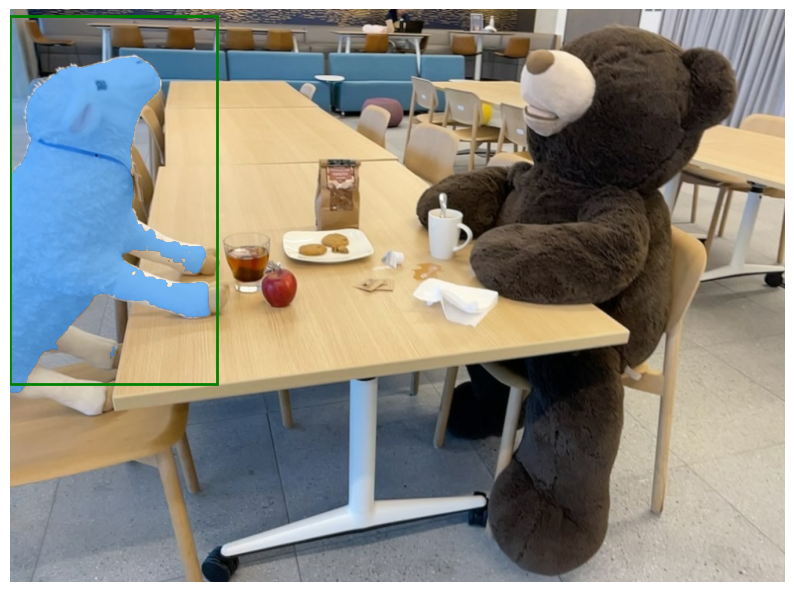

In [23]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
show_mask(masks[0], plt.gca())
show_box(input_box, plt.gca())
plt.axis('off')
plt.show()

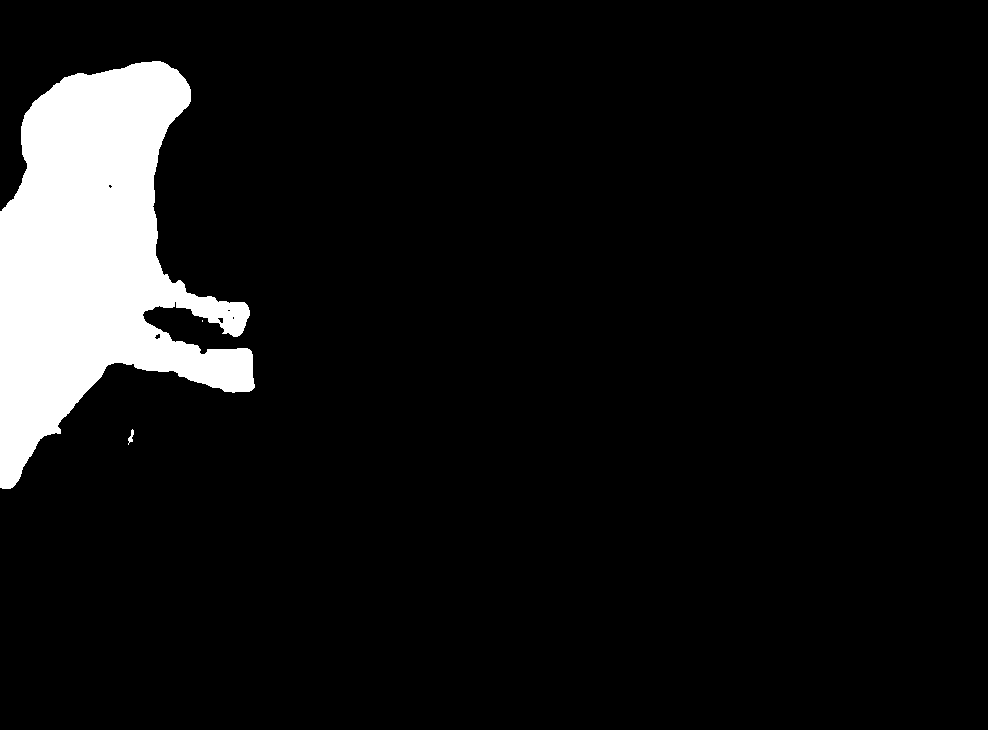

In [12]:
import numpy as np
from PIL import Image

len(masks)
mask_image = Image.fromarray(np.uint8(masks[0].squeeze() * 255), 'L')

# Save or display the image
mask_image.save('mask_image_from_text.png')  # Save the image to a file
mask_image.show()  # This will display the image